# STATS 542: Homework 3

<h4><center> Diego Kleiman (diegoek2) </center></h4>
<h4><center> Due: Monday 11:59 PM CT, Feb 23rd </center></h4>

## About HW3

In the first question, we will use a simulation study to confirm the theoretical analysis we developed during the lecture. In the second question, we will practice several linear model selection techniques such as AIC, BIC, and best subset selection. However, some difficulties are at the data processing part, in which we use the Bitcoin data from Kaggle. This is essentially a time-series data, and we use the information in previous days to predict the price in a future day. Make sure that you process the data correctly to fit this task. 

## Question 1 [40 Points] A Simulation Study

Let's use a simulation study to confirm the bias-variance trade-off of linear regressions. Consider the following model. 

$$Y = \sum_j^p 0.9^j \times X_j + \epsilon$$
All the covariates and the error term follow i.i.d. standard Gaussian distribution. The true model involves all the variables; however, variables with larger indexes do not contribute significantly to the variation. Hence, there could be a benefit using a smaller subset for prediction purposes. Let's confirm that with a simulation study. The study essentially repeats the following steps 200 times and obtain the averaged results:

  * Generate 300 training data (both covariates and outcomes) with $p=100$, and generate another 300 outcomes as the testing data $Y$ using the same covariate value.
  * Consider using only the first $j$ variables to fit the linear regression. Let $j$ ranges from 1 to 100. Calculate and record the corresponding prediction error. 
  * For each $j$ value, we also have the theoretical analysis of the testing error based on the lecture. In that analysis, we have the formula of both the Bias$^2$ and variance. Plug-in the simulated data to calculate the Bias$^2$ and use the theoretical value for the variance. 

After finishing all simulation runs, plot your results using the `number of variables` as the x-axis, and the following 4 lines:

  * The averaged prediction error based on your 200 simulation runs
  * The averaged Bias$^2$ based on your 200 simulation runs
  * The theoretical variance 
  * The sum of Bias$^2$ + variance + Irreducible Error

Does your simulation result match our theoretical analysis? Comment on your findings.

In [1]:
import numpy as np
from matplotlib import pyplot as plt
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error


In [2]:
plt.style.use('seaborn-poster')
plt.style.use('seaborn-darkgrid')


In [3]:
# Initilize arrays/asign variables

beta = np.asarray([0.9**j for j in range(1, 101)])
prediction_errors = np.zeros(100)
bias_terms = np.zeros(100)
trials = 200

# Repeat 200 times
for _ in range(trials):
    
    X = np.random.normal(0, 1, size=(300, 100))
    e_train = np.random.normal(0, 1, size=(300))
    e_test = np.random.normal(0, 1, size=(300))
    
    X_beta = np.matmul(X, beta)
    Y_train = X_beta + e_train
    Y_test = X_beta + e_test
    
    for j in range(100):
        
        # Fit model using first j covariates
        X_temp = X[:, :(j+1)]
        model = LinearRegression(fit_intercept=False).fit(X_temp, Y_train)
        
        # Predict on test data
        Y_hat = model.predict(X_temp)
        residuals = (Y_test-Y_hat)
        error = np.sum(residuals**2)
        
        # Compute hat matrix
        H = np.matmul(np.matmul(X_temp, np.linalg.inv(np.matmul(X_temp.T, X_temp))), X_temp.T)
        
        # Populate data vectors
        prediction_errors[j] += error/300
        bias_terms[j] += np.sum((X_beta - np.matmul(H, X_beta))**2)/300

# Divide by number of trials 
prediction_errors /= trials 
bias_terms /= trials


Theoretical values:

$$Variance = \frac{p\cdot\sigma^2}{n}$$
$$Irreducible\space error = \sigma^2$$

In [4]:
# Theoretical values
sigma = 1
n = 300
variance = np.arange(1, 101)*(sigma**2)/n
irr_error = np.ones(100)*(sigma**2)


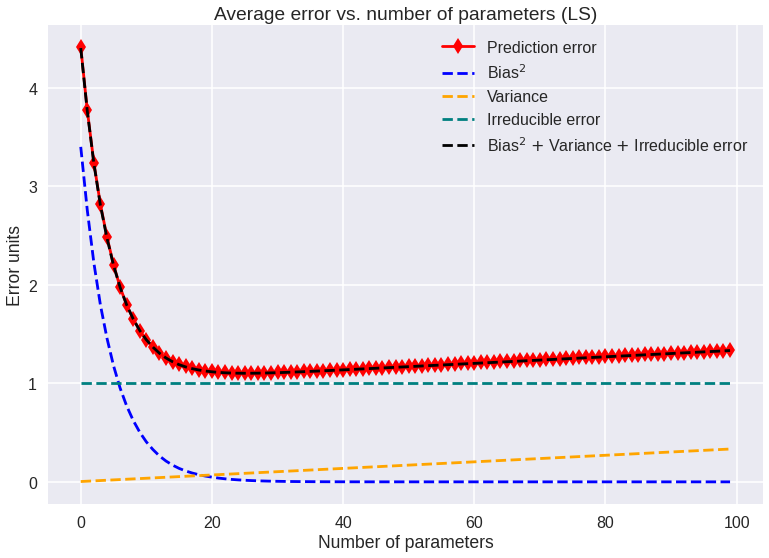

In [5]:
plt.plot(prediction_errors, 'd-', c='red')
plt.plot(bias_terms, '--', c='blue')
plt.plot(variance, '--', c='orange')
plt.plot(irr_error, '--', c='teal')
plt.plot(bias_terms + variance + irr_error, '--', c='black')
plt.title("Average error vs. number of parameters (LS)")
plt.legend(["Prediction error", "Bias$^2$", "Variance", "Irreducible error", "Bias$^2$ $+$ Variance $+$ Irreducible error"])
plt.xlabel("Number of parameters")
plt.ylabel("Error units")
plt.plot()
plt.show()
plt.close()


Does your simulation result match our theoretical analysis? Comment on your findings.

**Answer:** 

My simulation clearly matches our theoretical analysis. This is clear from the plot because the sum of the three error terms (Bias$^2$ $+$ Variance $+$ Irreducible error) shows excellent agreement with the test error from the simulations. 

## Question 2 [60 Points] Bitcoin price prediction

For this question, we will use the [Bitcoin data]() provided on the course website. The data were posted originally on Kaggle ([link](https://www.kaggle.com/sudalairajkumar/cryptocurrencypricehistory?select=bitcoin_cash_price.csv)). Make sure that you read relevant information from the Kaggle website. Our data is the `bitcoin_dataset.csv` file. You should use a training/testing split such that your training data is constructed using only information up to 12/31/2016, and your testing data is constructed using only information starting from 01/01/2017. The goal of our analysis is to predict the `btc_market_price`. Since this is longitudinal data, we will use the information from previous days to predict the market price at a future day. In particular, on each calendar day (say, day 1), we use the information from three days onward (days 1, 2, and 3) to predict the market price on the 7th day. 

Hence you need to first reconstruct the data properly to fit this purpose. This is mainly to put the outcome (of day 7) and the covariates (of the previous days) into the same row. Note that for this question, you may face issues such as missing data, categorical predictors, outliers, scaling issue, computational issue, and maybe others. Use your best judgment to deal with them. There is no general ''best answer''. Hence the grading will be based on whether you provided reasoning for your decision and whether you carried out the analysis correctly.

### [15 Points] Data Construction

Data pre-processing is usually the most time-consuming and difficult part of an analysis. We will use this example as a practice. Construct your data appropriately such that further analysis can be performed. Make sure that you consider the following:

  * The data is appropriate for our analysis goal: each row contains the outcome on the seventh day and the covariates of the first three days
  * Missing data is addressed (you can remove variable, remove observation, impute values or propose your own method)
  * Process each single covariate/outcome by considering centering/scaling/transformation and/or removing outliers
  
For each of the above tasks, make sure that you **clearly document your choice**. In the end, provide a summary table/figure of your data. You can consider using boxplots, quantiles, histogram, or any method that is easy for readers to understand. You are required to pick one at least one method to present. 

**Answer:**

I am following these steps:
1. Convert `Date` column to datetime type. This is just to create the train/test split.
1. Split data in training and testing sets. (Question requirement.)
1. Rearrange data by placing all covariates from days $n$ to $n+3$ in the same row and set `btc_market_price` of day $n+6$ as the outcome of said row for $n \in [1, N-6]$ where $N$ is the total number of days for which we have data in each dataset (train and test). (Question requirement.)
1. Drop rows where a column is missing. (This is a data processing decision that I consider appropriate since very few values were missing.)
1. Stardardize all covariates and outcome. I use stardardization because I want the data to be centered and scaled. I will use RobustScaler from sklearn as it is robust against outliers because it uses the median and interquartile range instead of the mean and standard deviation.

In [6]:
import pandas as pd
bitcoin_raw_data = pd.read_csv('bitcoin.csv') # Load data

In [7]:
bitcoin_raw_data.Date = pd.to_datetime(bitcoin_raw_data.Date) # Convert to datetime format

In [8]:
# Split test and train data
bitcoin_raw_train = bitcoin_raw_data[bitcoin_raw_data.Date <= '2016-12-31'] # Before or on 12/31/2016
bitcoin_raw_test = bitcoin_raw_data[bitcoin_raw_data.Date >= '2017-01-01'] # On or after 01/01/2017
bitcoin_raw_test = bitcoin_raw_test.reset_index(drop=True) # Make sure index starts at zero

In [9]:
# Get new (unique) column names for each column in design matrix
temp = bitcoin_raw_train.loc[:2, bitcoin_raw_train.columns != 'Date']
temp.index = temp.index + 1
temp2 = temp.stack()
temp2.index = temp2.index.map('{0[1]}_{0[0]}'.format)
new_column_names = temp2.to_frame().T.columns.to_list()

In [10]:
# Convert to numpy to rearrange data
bitcoin_raw_train_numpy = bitcoin_raw_train.to_numpy()
bitcoin_raw_test_numpy = bitcoin_raw_test.to_numpy()

# Drop "Date" column (they are ordered by index anyway)
bitcoin_raw_train_numpy = bitcoin_raw_train_numpy[:, 1:]
bitcoin_raw_test_numpy = bitcoin_raw_test_numpy[:, 1:]

# Build training dataset
N = bitcoin_raw_train.shape[0]
train_set = np.empty((N-6, 69)) # N-6 samples and 69 columns
train_outcomes = np.empty((N-6))
for n in range(N-6):
    row = bitcoin_raw_train_numpy[n:n+3].reshape(1, 69)
    train_set[n, :] = row
    train_outcomes[n] = bitcoin_raw_train_numpy[n+6, 0]
    
# Build testing dataset
N = bitcoin_raw_test.shape[0]
test_set = np.empty((N-6, 69)) # N-5 samples and 69 columns
test_outcomes = np.empty((N-6))
for n in range(N-6):
    row = bitcoin_raw_test_numpy[n:n+3].reshape(1, 69)
    test_set[n, :] = row
    test_outcomes[n] = bitcoin_raw_test_numpy[n+6, 0]

In [11]:
train_set = pd.DataFrame(np.append(train_set, train_outcomes.reshape(train_outcomes.shape[0], 1), axis=1), columns=new_column_names + ['outcome'])

In [12]:
train_set

,btc_market_price_1,btc_total_bitcoins_1,btc_market_cap_1,btc_trade_volume_1,btc_blocks_size_1,btc_avg_block_size_1,btc_n_orphaned_blocks_1,btc_n_transactions_per_block_1,btc_median_confirmation_time_1,btc_hash_rate_1,...,btc_cost_per_transaction_3,btc_n_unique_addresses_3,btc_n_transactions_3,btc_n_transactions_total_3,btc_n_transactions_excluding_popular_3,btc_n_transactions_excluding_chains_longer_than_100_3,btc_output_volume_3,btc_estimated_transaction_volume_3,btc_estimated_transaction_volume_usd_3,outcome
0,0.000000,2110700.0,0.000000e+00,0.000000e+00,0.000000,0.000216,0.0,1.000000,0.000000,3.153929e-05,...,0.000000,150.0,150.0,42959.0,150.0,150.0,8.100000e+03,700.000000,0.000000e+00,0.000000
1,0.000000,2120200.0,0.000000e+00,0.000000e+00,0.000000,0.000282,0.0,1.000000,0.000000,3.571305e-05,...,0.000000,176.0,176.0,43135.0,176.0,176.0,2.934900e+04,13162.000000,0.000000e+00,0.000000
2,0.000000,2127600.0,0.000000e+00,0.000000e+00,0.000000,0.000227,0.0,1.000000,0.000000,2.781859e-05,...,0.000000,176.0,176.0,43311.0,176.0,176.0,9.101000e+03,450.000000,0.000000e+00,0.000000
3,0.000000,2136100.0,0.000000e+00,0.000000e+00,0.000000,0.000319,0.0,1.000000,0.000000,3.195378e-05,...,0.000000,165.0,165.0,43476.0,165.0,165.0,1.339900e+04,5250.000000,0.000000e+00,0.000000
4,0.000000,2144750.0,0.000000e+00,0.000000e+00,0.000000,0.000223,0.0,1.000000,0.000000,3.251768e-05,...,0.000000,187.0,187.0,43663.0,187.0,187.0,1.030000e+04,1000.000000,0.000000e+00,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2493,824.218938,16056275.0,1.326698e+10,4.485404e+07,94932.381938,0.963966,0.0,2048.283019,8.783333,2.451435e+06,...,5.923338,522516.0,304997.0,181735754.0,237189.0,205183.0,2.633796e+06,431035.319296,3.892594e+08,930.376000
2494,860.599875,16058262.5,1.381557e+10,5.417773e+07,95078.635893,0.919836,0.0,1978.893082,8.583333,2.451435e+06,...,6.670388,420206.0,240820.0,181976574.0,195740.0,177864.0,1.526634e+06,223986.762894,2.003270e+08,967.480375
2495,901.318238,16060162.5,1.450361e+10,7.112861e+07,95213.610311,0.887990,0.0,2006.559211,12.775000,2.343510e+06,...,9.637165,353857.0,199614.0,182176188.0,241536.0,148365.0,1.105165e+06,232569.579907,2.080800e+08,963.381625
2496,891.612612,16061875.0,1.436526e+10,3.663265e+07,95330.730173,0.854890,0.0,1757.810219,16.325000,2.112243e+06,...,6.872294,448557.0,244914.0,182421102.0,292846.0,172836.0,1.513037e+06,270013.079151,2.439460e+08,952.156375


In [13]:
test_set = pd.DataFrame(np.append(test_set, test_outcomes.reshape(test_outcomes.shape[0], 1), axis=1), columns=new_column_names + ['outcome'])

In [14]:
test_set

,btc_market_price_1,btc_total_bitcoins_1,btc_market_cap_1,btc_trade_volume_1,btc_blocks_size_1,btc_avg_block_size_1,btc_n_orphaned_blocks_1,btc_n_transactions_per_block_1,btc_median_confirmation_time_1,btc_hash_rate_1,...,btc_cost_per_transaction_3,btc_n_unique_addresses_3,btc_n_transactions_3,btc_n_transactions_total_3,btc_n_transactions_excluding_popular_3,btc_n_transactions_excluding_chains_longer_than_100_3,btc_output_volume_3,btc_estimated_transaction_volume_3,btc_estimated_transaction_volume_usd_3,outcome
0,997.729875,16077350.0,1.614487e+10,3.399191e+07,96345.452397,0.698540,0.0,1157.064103,10.850000,2.463611e+06,...,7.418693,515023.0,301664.0,184640586.0,326689.0,200407.0,1.950525e+06,329964.393518,3.406882e+08,896.830375
1,1015.977112,16079337.5,1.644112e+10,5.759703e+07,96496.686192,0.945211,1.0,1835.512500,9.816667,2.526780e+06,...,7.300058,545635.0,330164.0,184970750.0,284086.0,215669.0,2.503952e+06,386434.819254,4.391832e+08,908.149037
2,1023.141875,16081387.5,1.660403e+10,4.155099e+07,96645.364249,0.906574,0.0,1839.414634,12.350000,2.589950e+06,...,6.438563,495909.0,288501.0,185259251.0,284086.0,193322.0,2.998215e+06,526684.339439,5.245776e+08,894.180250
3,1126.763338,16083300.0,1.827867e+10,1.431343e+08,96797.229978,0.986141,1.0,2143.922078,10.700000,2.432026e+06,...,5.471699,562749.0,346405.0,185605656.0,342362.0,233379.0,3.100652e+06,483798.943372,4.284523e+08,906.056914
4,994.674875,16085050.0,1.602071e+10,2.084983e+08,96935.017543,0.984197,0.0,2060.721429,10.916667,2.210933e+06,...,5.842191,503340.0,284719.0,185890375.0,280726.0,187066.0,2.162213e+06,344066.519218,3.102585e+08,785.223737
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
405,8319.876566,16857300.0,1.402507e+11,9.185402e+08,156085.952197,1.034792,0.0,1271.209790,9.450000,2.043482e+07,...,101.114203,437380.0,186918.0,299092204.0,183345.0,133062.0,1.674742e+06,181029.654089,1.595114e+09,10127.161667
406,8343.455000,16859187.5,1.406639e+11,7.963917e+08,156237.996989,1.006919,0.0,974.887417,7.533333,2.157803e+07,...,99.544224,414749.0,182984.0,299275188.0,179616.0,128687.0,1.315763e+06,146929.345775,1.263264e+09,10841.991667
407,8811.343333,16861262.5,1.485704e+11,8.366237e+08,156410.851393,1.041292,0.0,1126.012048,10.200000,2.372154e+07,...,109.366318,450367.0,196417.0,299471605.0,192621.0,140594.0,1.557017e+06,148097.503082,1.382436e+09,10503.298333
408,8597.767500,16863312.5,1.449868e+11,1.884544e+08,156580.256203,1.032956,0.0,1115.756098,11.050000,2.343574e+07,...,85.662879,475029.0,198183.0,299669788.0,194351.0,139075.0,1.418774e+06,129180.361091,1.288852e+09,11110.965000


In [15]:
# Check for missing data
train_set.isnull().values.any()

True

Since missing data were found in train_set, we will drop them.

In [16]:
train_set = train_set.dropna()

In [17]:
train_set

,btc_market_price_1,btc_total_bitcoins_1,btc_market_cap_1,btc_trade_volume_1,btc_blocks_size_1,btc_avg_block_size_1,btc_n_orphaned_blocks_1,btc_n_transactions_per_block_1,btc_median_confirmation_time_1,btc_hash_rate_1,...,btc_cost_per_transaction_3,btc_n_unique_addresses_3,btc_n_transactions_3,btc_n_transactions_total_3,btc_n_transactions_excluding_popular_3,btc_n_transactions_excluding_chains_longer_than_100_3,btc_output_volume_3,btc_estimated_transaction_volume_3,btc_estimated_transaction_volume_usd_3,outcome
0,0.000000,2110700.0,0.000000e+00,0.000000e+00,0.000000,0.000216,0.0,1.000000,0.000000,3.153929e-05,...,0.000000,150.0,150.0,42959.0,150.0,150.0,8.100000e+03,700.000000,0.000000e+00,0.000000
1,0.000000,2120200.0,0.000000e+00,0.000000e+00,0.000000,0.000282,0.0,1.000000,0.000000,3.571305e-05,...,0.000000,176.0,176.0,43135.0,176.0,176.0,2.934900e+04,13162.000000,0.000000e+00,0.000000
2,0.000000,2127600.0,0.000000e+00,0.000000e+00,0.000000,0.000227,0.0,1.000000,0.000000,2.781859e-05,...,0.000000,176.0,176.0,43311.0,176.0,176.0,9.101000e+03,450.000000,0.000000e+00,0.000000
3,0.000000,2136100.0,0.000000e+00,0.000000e+00,0.000000,0.000319,0.0,1.000000,0.000000,3.195378e-05,...,0.000000,165.0,165.0,43476.0,165.0,165.0,1.339900e+04,5250.000000,0.000000e+00,0.000000
4,0.000000,2144750.0,0.000000e+00,0.000000e+00,0.000000,0.000223,0.0,1.000000,0.000000,3.251768e-05,...,0.000000,187.0,187.0,43663.0,187.0,187.0,1.030000e+04,1000.000000,0.000000e+00,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2493,824.218938,16056275.0,1.326698e+10,4.485404e+07,94932.381938,0.963966,0.0,2048.283019,8.783333,2.451435e+06,...,5.923338,522516.0,304997.0,181735754.0,237189.0,205183.0,2.633796e+06,431035.319296,3.892594e+08,930.376000
2494,860.599875,16058262.5,1.381557e+10,5.417773e+07,95078.635893,0.919836,0.0,1978.893082,8.583333,2.451435e+06,...,6.670388,420206.0,240820.0,181976574.0,195740.0,177864.0,1.526634e+06,223986.762894,2.003270e+08,967.480375
2495,901.318238,16060162.5,1.450361e+10,7.112861e+07,95213.610311,0.887990,0.0,2006.559211,12.775000,2.343510e+06,...,9.637165,353857.0,199614.0,182176188.0,241536.0,148365.0,1.105165e+06,232569.579907,2.080800e+08,963.381625
2496,891.612612,16061875.0,1.436526e+10,3.663265e+07,95330.730173,0.854890,0.0,1757.810219,16.325000,2.112243e+06,...,6.872294,448557.0,244914.0,182421102.0,292846.0,172836.0,1.513037e+06,270013.079151,2.439460e+08,952.156375


In [18]:
test_set.isnull().values.any() 

False

Since we don't have any missing data in the test data, we don't have to drop any rows.

In [19]:
# Stardardizing columns
# Columns will be stardardized to make sure they follow a centered Gaussian distribution
from sklearn.preprocessing import RobustScaler

scaler = RobustScaler().fit(train_set)
train_set = scaler.transform(train_set)
test_set = scaler.transform(test_set)

### [15 Points] Model Selection Criterion

Use AIC and BIC criteria to select the best model and report the result from each of them. Use the forward selection for AIC and backward selection for BIC. Report the following two error quantities from **both training and testing data**. 

  * The mean squared error: $n^{-1} \sum_{i}(Y_i - \widehat{Y}_i)^2$
  * The proportion of explained variation ($R^2$): $1 - \frac{n^{-1} \sum_{i}(Y_i - \widehat{Y}_i)^2}{ n^{-1} \sum_{i}(Y_i - \overline{Y}_i)^2}$

Since these quantities can be affected by scaling and transformation, make sure that you **state any modifications applied to the outcome variable**. Compare the training data errors and testing data errors, which model works better? Provide a summary of your results. 

Note: I have applied [RobustScaler](https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.RobustScaler.html) on the outcome variable.

In [20]:
from statsmodels.regression.linear_model import OLS
from statsmodels.tools import add_constant # Will use to add intercept term

Select best model based on AIC using forward selection.

In [21]:
total_parameters = train_set.shape[1] - 1
remaining_parameters = np.asarray(range(total_parameters)).astype(int)
selected_parameters = np.asarray([]).astype(int) # We start with null model

y = train_set[:, -1]

best_AIC_prev = np.inf
best_AIC = 1e21
best_parameter_AIC = 1e20 # Initialize value to some big number
current_AIC = 0

while (remaining_parameters.size > 0) and (best_AIC < best_AIC_prev):
    
    best_parameter_AIC = 1e20 # Initialize value to some big number
    
    # Check which parameter is better to add
    for i in remaining_parameters:
        partial_train_set = train_set[:, np.append(selected_parameters, i)] # Add parameter i
        model = OLS(y, add_constant(partial_train_set)).fit()
        current_AIC = model.aic # Retrieve AIC for model
        if (current_AIC < best_parameter_AIC):
            best_parameter = i
            best_parameter_AIC = current_AIC
    
    # Check if model is better overall
    if (best_parameter_AIC < best_AIC):
        # Add new parameter to list of selected parameters
        selected_parameters = np.append(selected_parameters, best_parameter)
        # Remove parameter from remaining parameters
        remaining_parameters = remaining_parameters[remaining_parameters != best_parameter]
    
    # Update score so far
    best_AIC_prev = best_AIC
    best_AIC = best_parameter_AIC


In [22]:
# Lock-in best model from forward selection
best_model_forward = OLS(y, add_constant(train_set[:, selected_parameters])).fit()
selected_parameters_forward = selected_parameters

Features that were selected in forward selection:

In [23]:
print(np.asarray(new_column_names)[selected_parameters])

['btc_market_price_3' 'btc_estimated_transaction_volume_usd_3'
 'btc_estimated_transaction_volume_usd_2' 'btc_cost_per_transaction_3'
 'btc_miners_revenue_3' 'btc_n_transactions_per_block_3'
 'btc_avg_block_size_3' 'btc_trade_volume_3' 'btc_n_transactions_total_1'
 'btc_blocks_size_2' 'btc_total_bitcoins_1' 'btc_miners_revenue_1'
 'btc_n_transactions_2' 'btc_n_transactions_per_block_2'
 'btc_n_transactions_excluding_popular_3' 'btc_market_cap_1'
 'btc_estimated_transaction_volume_usd_1' 'btc_n_transactions_1'
 'btc_hash_rate_2' 'btc_transaction_fees_3' 'btc_blocks_size_3'
 'btc_n_transactions_3' 'btc_median_confirmation_time_3'
 'btc_n_unique_addresses_2' 'btc_transaction_fees_1'
 'btc_n_orphaned_blocks_1' 'btc_difficulty_3' 'btc_hash_rate_3'
 'btc_n_transactions_total_2']


Select best model based on BIC using backward selection.

In [24]:
total_parameters = train_set.shape[1] - 1
selected_parameters = np.asarray(range(total_parameters)).astype(int) # We start with full model

y = train_set[:, -1]

best_BIC_prev = np.inf
best_BIC = 1e21 # Initialize value to some big number
best_parameter_BIC = 1e20 # Initialize value to some big number
current_BIC = 0

while (selected_parameters.size > 0) and (best_BIC < best_BIC_prev):
    
    best_parameter_BIC = 1e20 # Initialize value to some big number
    
    # Check which parameter is better to remove
    for i in selected_parameters:
        parameters = selected_parameters[selected_parameters != i] # Remove parameter i
        partial_train_set = train_set[:, parameters]
        model = OLS(y, add_constant(partial_train_set)).fit()
        current_BIC = model.bic # Retrieve BIC for model
        if (current_BIC < best_parameter_BIC):
            best_parameter_to_remove = i
            best_parameter_BIC = current_BIC
    
    # Check if model is better overall
    if (best_parameter_BIC < best_BIC):
        # Remove parameter from selected parameters
        selected_parameters = selected_parameters[selected_parameters != best_parameter_to_remove]
    
    # Update score so far
    best_BIC_prev = best_BIC
    best_BIC = best_parameter_BIC

In [25]:
# Lock-in best model from backward selection
best_model_backward = OLS(y, add_constant(train_set[:, selected_parameters])).fit()
selected_parameters_backward = selected_parameters

Features that were selected in backward selection:

In [26]:
print(np.asarray(new_column_names)[selected_parameters])

['btc_market_cap_1' 'btc_miners_revenue_1' 'btc_n_transactions_total_1'
 'btc_blocks_size_2' 'btc_n_transactions_2'
 'btc_estimated_transaction_volume_usd_2' 'btc_market_price_3'
 'btc_total_bitcoins_3' 'btc_trade_volume_3'
 'btc_n_transactions_per_block_3' 'btc_hash_rate_3' 'btc_difficulty_3'
 'btc_miners_revenue_3' 'btc_cost_per_transaction_3'
 'btc_n_transactions_3' 'btc_n_transactions_total_3'
 'btc_estimated_transaction_volume_usd_3']


### Error reporting

Errors from AIC model (forward selection)

In [27]:
AIC_forward = best_model_forward.aic
BIC_forward = best_model_forward.bic
MSE_forward_train = np.mean((train_set[:, -1] - best_model_forward.predict(add_constant(train_set[:, selected_parameters_forward])))**2)
MSE_forward_test = np.mean((test_set[:, -1] - best_model_forward.predict(add_constant(test_set[:, selected_parameters_forward])))**2)
R2_forward_train = best_model_forward.rsquared
R2_forward_test = 1 - (MSE_forward_test/np.mean((test_set[:, -1] - np.mean(test_set[:, -1]))**2))

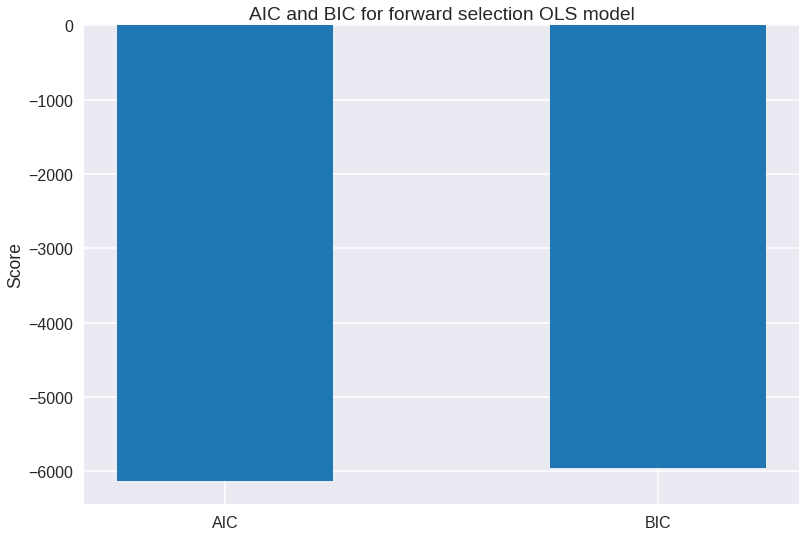

In [28]:
x = [0.5, 1.5]
plt.bar(x, [AIC_forward, BIC_forward], width=0.5)
plt.xticks(x, labels=["AIC", "BIC"])
plt.ylabel("Score")
plt.title("AIC and BIC for forward selection OLS model")
plt.show()
plt.close()

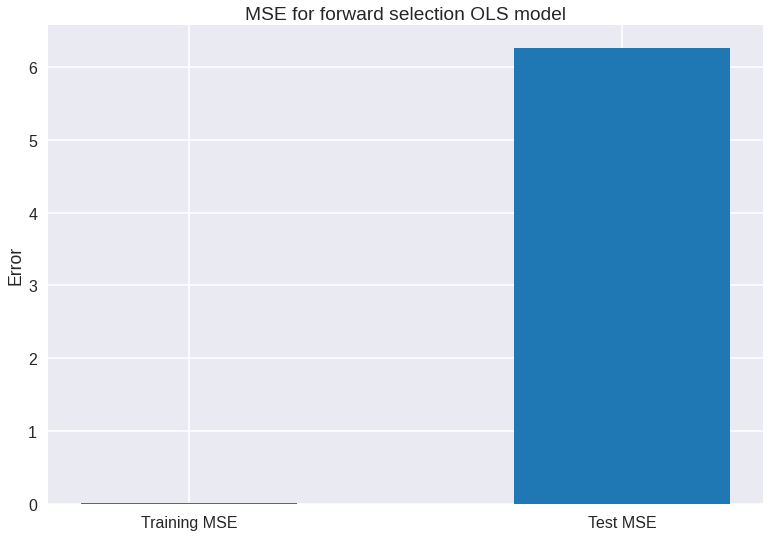

In [29]:
x = [0.5, 1.5]
plt.bar(x, [MSE_forward_train, MSE_forward_test], width=0.5)
plt.xticks(x, labels=["Training MSE", "Test MSE"])
plt.ylabel("Error")
plt.title("MSE for forward selection OLS model")
plt.show()
plt.close()

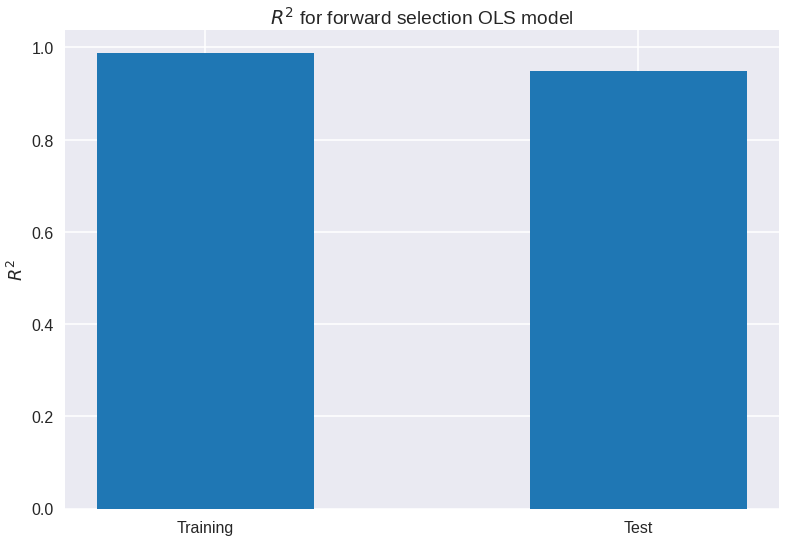

In [30]:
x = [0.5, 1.5]
plt.bar(x, [R2_forward_train, R2_forward_test], width=0.5)
plt.xticks(x, labels=["Training", "Test"])
plt.ylabel("$R^2$")
plt.title("$R^2$ for forward selection OLS model")
plt.show()
plt.close()

Errors from BIC model (backward selection)

In [31]:
AIC_backward = best_model_backward.aic
BIC_backward = best_model_backward.bic
MSE_backward_train = np.mean((train_set[:, -1] - best_model_backward.predict(add_constant(train_set[:, selected_parameters_backward])))**2)
MSE_backward_test = np.mean((test_set[:, -1] - best_model_backward.predict(add_constant(test_set[:, selected_parameters_backward])))**2)
R2_backward_train = best_model_backward.rsquared
R2_backward_test = 1 - (MSE_backward_test/np.mean((test_set[:, -1] - np.mean(test_set[:, -1]))**2))

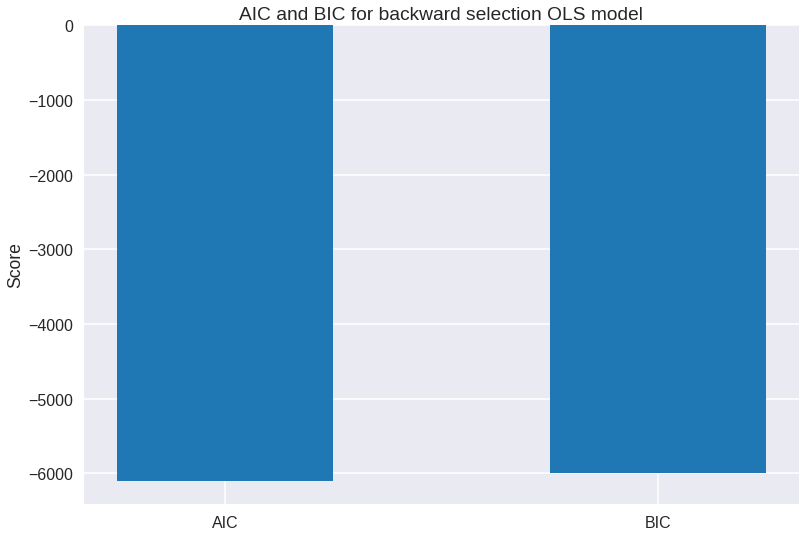

In [32]:
x = [0.5, 1.5]
plt.bar(x, [AIC_backward, BIC_backward], width=0.5)
plt.xticks(x, labels=["AIC", "BIC"])
plt.ylabel("Score")
plt.title("AIC and BIC for backward selection OLS model")
plt.show()
plt.close()

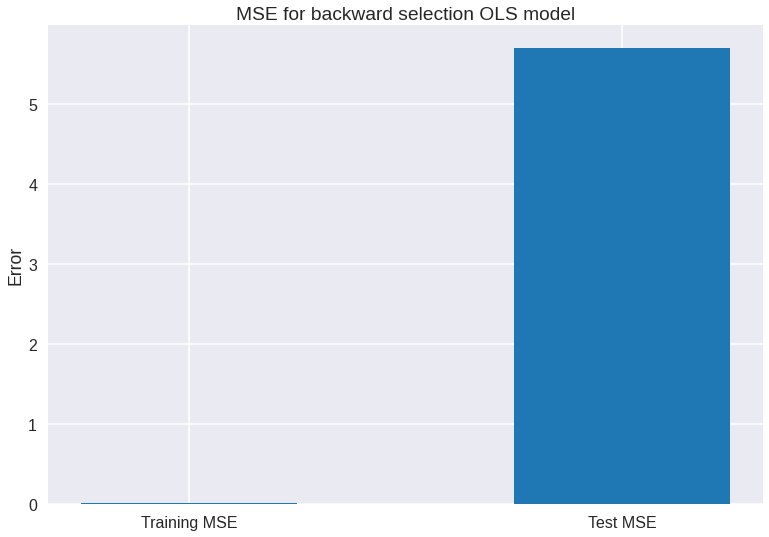

In [33]:
x = [0.5, 1.5]
plt.bar(x, [MSE_backward_train, MSE_backward_test], width=0.5)
plt.xticks(x, labels=["Training MSE", "Test MSE"])
plt.ylabel("Error")
plt.title("MSE for backward selection OLS model")
plt.show()
plt.close()

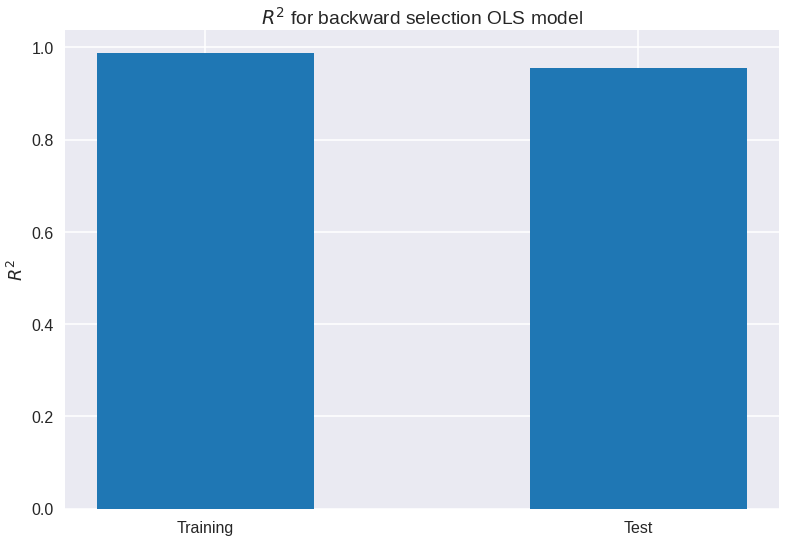

In [34]:
x = [0.5, 1.5]
plt.bar(x, [R2_backward_train, R2_backward_test], width=0.5)
plt.xticks(x, labels=["Training", "Test"])
plt.ylabel("$R^2$")
plt.title("$R^2$ for backward selection OLS model")
plt.show()
plt.close()

Compare the training data errors and testing data errors, which model works better? Provide a summary of your results.

In [35]:
print("MSE forward test error:", MSE_forward_test)
print("MSE forward train error:", MSE_forward_train)
print("R-squared forward test:", R2_forward_test)
print("R-squared forward train:", R2_forward_train)
print("AIC forward:", AIC_forward)
print("BIC forward:", BIC_forward)

MSE forward test error: 6.26450254546285
MSE forward train error: 0.004685830924388568
R-squared forward test: 0.9494722582022483
R-squared forward train: 0.9878671570446053
AIC forward: -6126.5453027080075
BIC forward: -5958.245686056394


In [36]:
print("MSE backward test error:", MSE_backward_test)
print("MSE backward train error:", MSE_backward_train)
print("R-squared backward test:", R2_backward_test)
print("R-squared backward train:", R2_backward_train)
print("AIC backward:", AIC_backward)
print("BIC backward:", BIC_backward)

MSE backward test error: 5.6939683521808355
MSE backward train error: 0.004781754675615563
R-squared backward test: 0.954074028924781
R-squared backward train: 0.9876187853410356
AIC backward: -6100.918013230734
BIC backward: -6002.259617262547


**Answer:**

We can see from the results that the model from forward selection seems to be overfitting more that the model from backward selection. This is evident from the fact that the training error is smaller for the forward selection model, but the testing error is smaller for the backward selection model.

The $R^2$ values show that the forward selection model explains a slightly higher amount of the variance from the test set, but this comes at the cost of a much more complex model (more degrees of freedom) that overfits the data. In fact, we can see that for the test data, $R^2$ for the backward selection model is closer to $1$.

We used different metrics (AIC and BIC) to select optimal models in each case. In this case, it seems that the model from backward selection with BIC performs better.

More details of each model are shown below.

In [37]:
best_model_forward.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                      y   R-squared:                       0.988
Model:                            OLS   Adj. R-squared:                  0.988
Method:                 Least Squares   F-statistic:                     7037.
Date:                Mon, 22 Feb 2021   Prob (F-statistic):               0.00
Time:                        05:16:36   Log-Likelihood:                 3092.3
No. Observations:                2449   AIC:                            -6127.
Df Residuals:                    2420   BIC:                            -5958.
Df Model:                          28                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0186      0.006      3.216      0.001       0.007       0.030
x1             0.9438      0.034     28.135      0.000       0.878       1.010
x2             0.0177      0.005      3.678      0.000       0.008       0.027
x3             0.0169      0.005      3.463      0.001       0.007       0.027
x4             0.0228      0.003      7.170      0.000       0.017       0.029
x5            -0.0948      0.017     -5.461      0.000      -0.129      -0.061
x6             0.0461      0.012      3.775      0.000       0.022       0.070
x7            -0.0389      0.037     -1.061      0.289      -0.111       0.033
x8             0.0069      0.002      3.493      0.000       0.003       0.011
x9             0.8064      0.078     10.307      0.000       0.653       0.960
x10          -20.9790     24.480     -0.857      0.392     -68.983      27.025
x11           -0.0562      0.011     -5.098      0.000      -0.078      -0.035
x12            0.0641      0.014      4.741      0.000       0.038       0.091
x13           -0.0154      0.018     -0.843      0.399      -0.051       0.020
x14            0.0452      0.012      3.681      0.000       0.021       0.069
x15            0.0501      0.015      3.408      0.001       0.021       0.079
x16           -0.1026      0.032     -3.193      0.001      -0.166      -0.040
x17            0.0133      0.004      2.981      0.003       0.005       0.022
x18           -0.0296      0.014     -2.125      0.034      -0.057      -0.002
x19            0.0238      0.010      2.421      0.016       0.005       0.043
x20           -0.0054      0.003     -1.868      0.062      -0.011       0.000
x21           19.5360     24.541      0.796      0.426     -28.588      67.660
x22           -0.0581      0.023     -2.559      0.011      -0.103      -0.014
x23            0.0091      0.005      1.993      0.046       0.000       0.018
x24           -0.0357      0.017     -2.105      0.035      -0.069      -0.002
x25           -0.0041      0.003     -1.520      0.129      -0.009       0.001
x26           -0.0035      0.002     -1.799      0.072      -0.007       0.000
x27           -0.0458      0.022     -2.043      0.041      -0.090      -0.002
x28            0.0282      0.019      1.478      0.139      -0.009       0.066
x29            0.8050      0.078     10.307      0.000       0.652       0.958
==============================================================================
Omnibus:                      851.724   Durbin-Watson:                   0.482
Prob(Omnibus):                  0.000   Jarque-Bera (JB):           143502.491
Skew:                          -0.478   Prob(JB):                         0.00
Kurtosis:                      40.489   Cond. No.                     2.25e+15
==============================================================================

N

In [38]:
best_model_backward.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                      y   R-squared:                       0.988
Model:                            OLS   Adj. R-squared:                  0.988
Method:                 Least Squares   F-statistic:                 1.212e+04
Date:                Mon, 22 Feb 2021   Prob (F-statistic):               0.00
Time:                        05:16:36   Log-Likelihood:                 3067.5
No. Observations:                2449   AIC:                            -6101.
Df Residuals:                    2432   BIC:                            -6002.
Df Model:                          16                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0147      0.003      4.427      0.000       0.008       0.021
x1            -0.0949      0.031     -3.020      0.003      -0.157      -0.033
x2             0.0606      0.013      4.693      0.000       0.035       0.086
x3             0.6804      0.069      9.879      0.000       0.545       0.815
x4            -1.2378      0.127     -9.757      0.000      -1.487      -0.989
x5            -0.0308      0.013     -2.288      0.022      -0.057      -0.004
x6             0.0213      0.004      4.796      0.000       0.013       0.030
x7             0.9459      0.032     29.713      0.000       0.883       1.008
x8            -0.0469      0.009     -5.485      0.000      -0.064      -0.030
x9             0.0069      0.002      3.475      0.001       0.003       0.011
x10            0.0621      0.011      5.880      0.000       0.041       0.083
x11            0.0490      0.010      4.822      0.000       0.029       0.069
x12           -0.0380      0.012     -3.288      0.001      -0.061      -0.015
x13           -0.0835      0.016     -5.300      0.000      -0.114      -0.053
x14            0.0210      0.003      7.052      0.000       0.015       0.027
x15           -0.0429      0.015     -2.933      0.003      -0.072      -0.014
x16            0.6780      0.069      9.878      0.000       0.543       0.813
x17            0.0207      0.005      4.373      0.000       0.011       0.030
==============================================================================
Omnibus:                      802.717   Durbin-Watson:                   0.490
Prob(Omnibus):                  0.000   Jarque-Bera (JB):           145573.692
Skew:                          -0.293   Prob(JB):                         0.00
Kurtosis:                      40.766   Cond. No.                     1.85e+16
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The smallest eigenvalue is 9.95e-29. This might indicate that there are
strong multicollinearity problems or that the design matrix is singular.
"""

### [15 Points] Best Subset Selection

Fit the best subset selection to the dataset and report the best model of each model size (up to 7 variables, excluding the intercept) and their prediction errors. Make sure that you simplify your output so that it only presents the essential information. If the algorithm cannot handle this many variables, then consider using just day 1 and 2 information. 

Note: since there are too many combinations and the code would take too long, I will apply PCA to reduce the number of variables to a manageable number.

In [39]:
from sklearn.decomposition import PCA
pca_transformer = PCA(n_components=20).fit(train_set[:, :-1])
X = pca_transformer.transform(train_set[:, :-1])
X_test = pca_transformer.transform(test_set[:, :-1])

In [40]:
X.shape

(2449, 20)

In [41]:
X_test.shape

(410, 20)

In [42]:
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error

In [43]:
def fit_and_score(X, y):
    n_samples = X.shape[0]
    model = LinearRegression().fit(X, y)
    RSS = mean_squared_error(y, model.predict(X)) * n_samples
    return model, RSS

In [44]:
from itertools import combinations

In [45]:
y = train_set[:, -1]
max_params = 7
total_params = X.shape[1]
best_models = []
best_params = []

for k in range(1, max_params + 1):
    
    print("Step", k, "of 7.")
    rss_prev = np.inf
    
    for comb in combinations(np.arange(total_params), k): #All combinations of k parameters 
        X_partial = X[:, np.asarray(comb)]
        temp_model, rss = fit_and_score(X_partial, y)
        if (rss < rss_prev):
            best_model = temp_model
            rss_prev = rss
            best_p = np.asarray(comb)
    
    best_models.append(best_model)
    best_params.append(best_p)

Step 1 of 7.
Step 2 of 7.
Step 3 of 7.
Step 4 of 7.
Step 5 of 7.
Step 6 of 7.
Step 7 of 7.


In [46]:
for k in range(max_params):
    print("Coefficient(s) of best model with", k+1, "parameter(s):", best_models[k].coef_)
    print("Parameters used (indices):", best_params[k])
    print("Intercept:", best_models[k].intercept_)
    print('--------------------------------------------------------------')

Coefficient(s) of best model with 1 parameter(s): [0.07972952]
Parameters used (indices): [3]
Intercept: 0.2651805639256272
--------------------------------------------------------------
Coefficient(s) of best model with 2 parameter(s): [0.07972952 0.10281607]
Parameters used (indices): [3 4]
Intercept: 0.2651805639256272
--------------------------------------------------------------
Coefficient(s) of best model with 3 parameter(s): [ 0.07972952  0.10281607 -0.03936328]
Parameters used (indices): [3 4 7]
Intercept: 0.2651805639256273
--------------------------------------------------------------
Coefficient(s) of best model with 4 parameter(s): [-9.03270133e-05  7.97295227e-02  1.02816068e-01 -3.93632770e-02]
Parameters used (indices): [0 3 4 7]
Intercept: 0.2651805639256272
--------------------------------------------------------------
Coefficient(s) of best model with 5 parameter(s): [-9.03270133e-05  7.97295227e-02  1.02816068e-01 -3.93632770e-02
  4.46400126e-02]
Parameters used (i

In [47]:
y_train = train_set[:, -1]
y_test = test_set[:, -1]
train_errors = []
test_errors = []

for k in range(max_params):
    train_error = mean_squared_error(y_train, best_models[k].predict(X[:, best_params[k]]))
    test_error = mean_squared_error(y_test, best_models[k].predict(X_test[:, best_params[k]]))
    
    train_errors.append(train_error)
    test_errors.append(test_error)

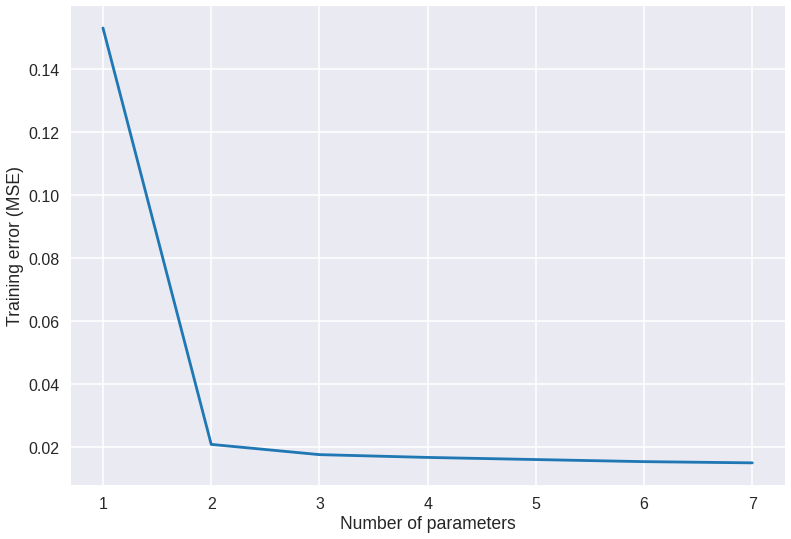

In [56]:
x = np.arange(1, max_params+1)
plt.plot(x, train_errors)
plt.xlabel("Number of parameters")
plt.ylabel("Training error (MSE)")
plt.show()
plt.close()

In [49]:
x[np.asarray(train_errors).argmin()]

7

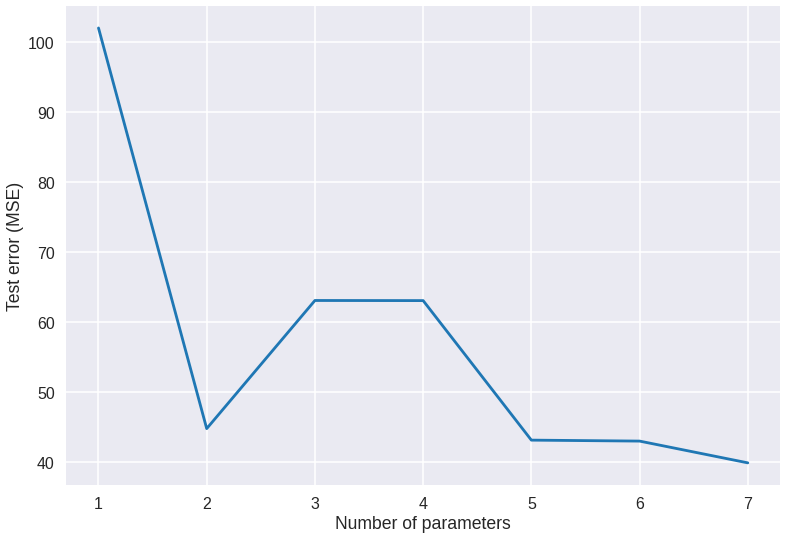

In [55]:
x = np.arange(1, max_params+1)
plt.plot(x, test_errors)
plt.xlabel("Number of parameters")
plt.ylabel("Test error (MSE)")
plt.show()
plt.close()

In [51]:
x[np.asarray(test_errors).argmin()]

7

Conclusion: the best model is the one with 7 parameters.


### [15 Points] KNN

Use KNN to perform this prediction task. Do you expect KNN to perform better or worse than the linear model, and why? Does the analysis result match your intuition? Report your model fitting results.

In [52]:
from sklearn.neighbors import KNeighborsRegressor
knn_regressor = KNeighborsRegressor(n_neighbors=5).fit(train_set[:, :-1], train_set[:, -1])
train_error_knn = mean_squared_error(train_set[:, -1], knn_regressor.predict(train_set[:, :-1]))
test_error_knn = mean_squared_error(test_set[:, -1], knn_regressor.predict(test_set[:, :-1]))

In [53]:
print("Training error:", train_error_knn)
print("Test error:", test_error_knn)

Training error: 0.004251550755666209
Test error: 227.19038460993252


In [54]:
print("Model parameters:", knn_regressor.get_params())

Model parameters: {'algorithm': 'auto', 'leaf_size': 30, 'metric': 'minkowski', 'metric_params': None, 'n_jobs': None, 'n_neighbors': 5, 'p': 2, 'weights': 'uniform'}


Do you expect KNN to perform better or worse than the linear model, and why? Does the analysis result match your intuition? Report your model fitting results.

**Answer:**

I expected KNN to perform worse, because these models tend to have high variance and low bias. It is clear from the test error and training error that the KNN model is overfitting (so the high variance problem proved real). The best linear model (found with backward selection) performed much better: although it had a similar training error, it also showed a much lower test error. For these reasons, I can conclude that the results matched my intuition.